In [83]:
from sklearnex import patch_sklearn
patch_sklearn()

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import xgboost as xgb
import numpy as np
import pickle,itertools
import shap
from sklearn.model_selection import train_test_split
plt.rcParams["figure.figsize"] = (10,7)

import pickle

import warnings
warnings.filterwarnings('ignore')

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [85]:
train_set = pd.read_csv('../data/train_df_expanded_KNN_imp_feats.csv')
train_set = train_set.replace([np.inf, -np.inf], np.nan)

y_train = train_set['Target']
x_train = train_set.drop(['Date', 'Target','Abs Target'], axis=1)
    
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.45, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.66, shuffle=False)
X_val_2, X_test, y_val_2, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=False)


X_val = X_val.iloc[5:]
y_val = y_val.iloc[5:]

X_train.columns=train_set.drop(['Date', 'Target','Abs Target'], axis=1).columns
X_val.columns=X_train.columns
X_test.columns=X_train.columns  

In [86]:
params = {'alpha': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'colsample_bylevel': 1, 'eta': 0.05, 'eval_metric': ['rmse'],
          'lambda': 1, 'max_depth': 4, 'objective': 'reg:squarederror', 'scale_pos_weight': 1, 'subsample': 0.7, 'tree_method': 'exact',
          'nthread': -2, 'base_score': 0}
dtrain = xgb.DMatrix(X_train[X_train['Target > 2']==1].drop(columns=['Target > 2']), y_train[X_train['Target > 2']==1])
dval = xgb.DMatrix(X_val[X_val['Target > 2']==1].drop(columns=['Target > 2']), y_val[X_val['Target > 2']==1])

reg = xgb.train(params,dtrain,evals=[(dtrain, 'train'),(dval, 'test')],num_boost_round=180,verbose_eval=True,early_stopping_rounds=10)

[0]	train-rmse:16.92812	test-rmse:20.36992
[1]	train-rmse:16.31813	test-rmse:19.66148
[2]	train-rmse:15.71521	test-rmse:18.88841
[3]	train-rmse:15.14716	test-rmse:18.15490
[4]	train-rmse:14.62143	test-rmse:17.48037
[5]	train-rmse:14.09150	test-rmse:16.83459
[6]	train-rmse:13.59909	test-rmse:16.18995
[7]	train-rmse:13.12395	test-rmse:15.59445
[8]	train-rmse:12.66585	test-rmse:15.03660
[9]	train-rmse:12.23908	test-rmse:14.51848
[10]	train-rmse:11.82498	test-rmse:14.01216
[11]	train-rmse:11.44223	test-rmse:13.51489
[12]	train-rmse:11.07773	test-rmse:13.08315
[13]	train-rmse:10.74458	test-rmse:12.69251
[14]	train-rmse:10.41867	test-rmse:12.33370
[15]	train-rmse:10.10020	test-rmse:11.93165
[16]	train-rmse:9.81138	test-rmse:11.56936
[17]	train-rmse:9.51706	test-rmse:11.17748
[18]	train-rmse:9.25282	test-rmse:10.84128
[19]	train-rmse:9.00825	test-rmse:10.52336
[20]	train-rmse:8.77126	test-rmse:10.23692
[21]	train-rmse:8.55949	test-rmse:10.00820
[22]	train-rmse:8.35136	test-rmse:9.81416
[23]	t

In [88]:
y_pred_train = reg.predict(dtrain)
y_pred_val = reg.predict(dval)
feat_importance = reg.get_score(importance_type='gain')
feat_importance = {k: v for k, v in sorted(feat_importance.items(), key=lambda item: item[1], reverse=True)}
top_10_gain = list(feat_importance.keys())[:10]

feat_importance = reg.get_score(importance_type='weight')
feat_importance = {k: v for k, v in sorted(feat_importance.items(), key=lambda item: item[1], reverse=True)}
top_10_weight = list(feat_importance.keys())[:10]

explainer = shap.TreeExplainer(reg)
shap_values = explainer(X_train[X_train['Target > 2']==1].drop(columns=['Target > 2']))
shap_summary = pd.DataFrame(shap_values.values, columns=X_train[X_train['Target > 2']==1].drop(columns=['Target > 2']).columns)
mean_abs_shap_values = shap_summary.abs().mean().sort_values(ascending=False)
top_10_shap = mean_abs_shap_values.head(10).index.tolist()

top_K_feat = list(set(top_10_gain+top_10_weight+top_10_shap))

with open("./sandbox_output/top_K_feat_from_3k_reg_true_labels.pkl", "wb") as f:
    pickle.dump(top_K_feat, f)

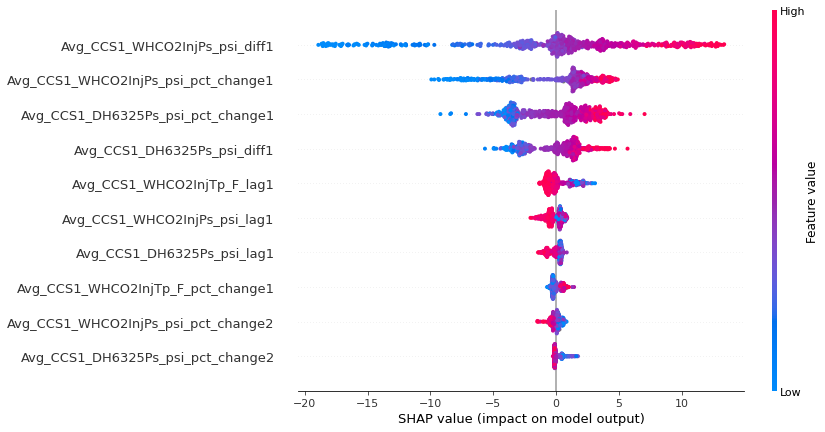

In [90]:
shap.summary_plot(shap_values, X_train[X_train['Target > 2']==1].drop(columns=['Target > 2']),
                   plot_size=(10, 7), max_display=10)

## Hyperparameter Tunning

In [91]:
y_train = train_set['Target']
x_train = train_set.drop(['Date', 'Target'], axis=1)
    
x_train = x_train[list(top_K_feat) +['Target > 2'] ]

X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.3, shuffle=False)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, shuffle=False)


X_val = X_val.iloc[5:]
y_val = y_val.iloc[5:]


In [92]:

dtrain = xgb.DMatrix(X_train[X_train['Target > 2']==1].drop(columns=['Target > 2']), y_train[X_train['Target > 2']==1])
dval = xgb.DMatrix(X_val[X_val['Target > 2']==1].drop(columns=['Target > 2']), y_val[X_val['Target > 2']==1])

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'alpha': [1, 5],
    'lambda': [1, 5],
    'colsample_bytree': [0.7, 1],
    'colsample_bylevel': [0.7, 1],
    'subsample': [0.7, 1],
    'tree_method': ['exact'],
    'nthread': [-2],
    'eta': [0.05],
    'max_depth': [4], 
    'objective': ['reg:squarederror'],
}

# Create a list of all combinations of hyperparameters
keys, values = zip(*param_grid.items())
hyperparameter_combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

In [93]:
y_test2=y_val[X_val['Target > 2']==1]
y_test2.reset_index(drop=True,inplace=True)

# Initialize empty lists to store results
rmse_scores=[]
MAPE_scores=[]
hyparparams_list = []
num_trees_list = []

for hyperparams in hyperparameter_combinations:
    # Train your model with the current hyperparameters
    reg = xgb.train(hyperparams,dtrain,evals=[(dtrain, 'train'),(dval, 'test')],num_boost_round=1000,verbose_eval=False,early_stopping_rounds=5)

    # Make predictions on the test set
    y_pred_train = reg.predict(dtrain)
    y_pred_val = reg.predict(dval)

    num_trees = reg.best_ntree_limit
    num_trees_list.append(num_trees)

    rmse = np.sqrt(mean_squared_error(y_val[X_val['Target > 2']==1], y_pred_val))
    print('RMSE: {:.2f}'.format(rmse))
    rmse_scores.append(rmse)
    
    MAPE=mean_absolute_percentage_error(y_test2, y_pred_val, sample_weight=np.abs(y_test2)/sum(np.abs(y_test2)))
    print('MAPE: {:.2f}%'.format(MAPE))
    MAPE_scores.append(MAPE)

# Combine the results into a list of dictionaries
results = []
for i, hyperparams in enumerate(hyperparameter_combinations):
    results.append({
        'hyperparameters': hyperparams,
        'RMSE': rmse_scores[i],
        'MAPE': MAPE_scores[i],
    })

RMSE: 7.12
MAPE: 0.29%
RMSE: 7.00
MAPE: 0.27%
RMSE: 7.07
MAPE: 0.28%
RMSE: 7.05
MAPE: 0.27%
RMSE: 7.08
MAPE: 0.27%
RMSE: 7.11
MAPE: 0.28%
RMSE: 7.07
MAPE: 0.28%
RMSE: 7.06
MAPE: 0.28%
RMSE: 7.05
MAPE: 0.28%
RMSE: 7.10
MAPE: 0.28%
RMSE: 7.10
MAPE: 0.28%
RMSE: 7.17
MAPE: 0.29%
RMSE: 7.01
MAPE: 0.27%
RMSE: 7.16
MAPE: 0.28%
RMSE: 7.05
MAPE: 0.27%
RMSE: 6.98
MAPE: 0.27%
RMSE: 7.16
MAPE: 0.29%
RMSE: 7.06
MAPE: 0.28%
RMSE: 7.09
MAPE: 0.28%
RMSE: 7.11
MAPE: 0.28%
RMSE: 7.01
MAPE: 0.27%
RMSE: 7.07
MAPE: 0.27%
RMSE: 7.09
MAPE: 0.28%
RMSE: 7.18
MAPE: 0.28%
RMSE: 7.03
MAPE: 0.27%
RMSE: 7.10
MAPE: 0.28%
RMSE: 7.18
MAPE: 0.29%
RMSE: 7.13
MAPE: 0.28%
RMSE: 7.16
MAPE: 0.28%
RMSE: 7.08
MAPE: 0.27%
RMSE: 7.00
MAPE: 0.27%
RMSE: 7.02
MAPE: 0.27%


In [94]:
# Find the best hyperparameters based on the highest AUCPR
best_idx = np.argmin([x['RMSE'] for x in results])

# Get the best threshold, hyperparameters, and optimal number of trees
best_hyperparams = results[best_idx]['hyperparameters']
opt_num_trees = num_trees_list[best_idx]

print(results[best_idx])
print(f'Num of trees: {opt_num_trees}')

{'hyperparameters': {'alpha': 1, 'lambda': 5, 'colsample_bytree': 1, 'colsample_bylevel': 1, 'subsample': 1, 'tree_method': 'exact', 'nthread': -2, 'eta': 0.05, 'max_depth': 4, 'objective': 'reg:squarederror'}, 'RMSE': 6.978748175675841, 'MAPE': 0.2712536391037794}
Num of trees: 86


## Testing results on validation set

In [102]:
with open("./output/y_train3_clf_preds.pkl", "rb") as f:
    y_pred_val_class = pickle.load(f)

In [103]:
y_train = train_set['Target']
x_train = train_set.drop(['Date', 'Target'], axis=1)
    
x_train = x_train[list(top_K_feat) +['Target > 2'] ]

X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.15, shuffle=False)

X_test = X_test.iloc[5:]
y_test = y_test.iloc[5:]

dtrain = xgb.DMatrix(X_train[X_train['Target > 2']==1].drop(columns=['Target > 2']), y_train[X_train['Target > 2']==1])

X_test['Class']=y_pred_val_class[-4114:]
dval = xgb.DMatrix(X_test[X_test['Class']==1].drop(columns=['Class','Target > 2']), y_test[X_test['Class']==1])

reg= xgb.train(best_hyperparams,dtrain,num_boost_round=int(opt_num_trees*1.09))

preds_reg=reg.predict(dval)
rmse_class_1 = np.sqrt(mean_squared_error( y_test[X_test['Class']==1], preds_reg))
rmse_class_1

7.428543618124273

In [105]:
reg.save_model('./sandbox_output/reg_true_labels_val.json')

In [104]:
X_test['Target']=y_test
X_test['Prediction']=0
X_test['Prediction'][X_test['Class']==1]=preds_reg
rmse = np.sqrt(mean_squared_error(X_test['Target'], X_test['Prediction']))
rmse

1.4123021615327205

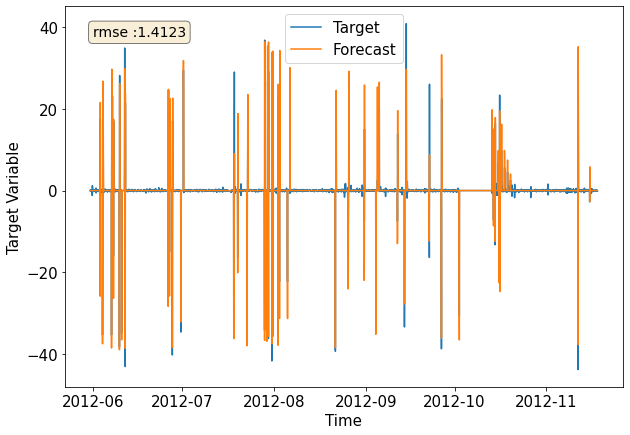

In [101]:
train_set['Date']=pd.to_datetime(train_set['Date'])
# plot the forecasted values against the real values
plt.plot(train_set['Date'][len(X_train)+5:], X_test['Target'], label='Target')
plt.plot(train_set['Date'][len(X_train)+5:], X_test['Prediction'], label='Forecast')
textstr = 'rmse :' + str(rmse.round(4)) 
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=14,
         verticalalignment='top', bbox=props)
plt.xlabel('Time')
plt.ylabel('Target Variable')
plt.rcParams.update({'font.size': 15})
plt.legend()
plt.show()

In [99]:
y_train = train_set['Target']
x_train = train_set.drop(['Date', 'Target'], axis=1)
    
x_train = x_train[list(top_K_feat) +['Target > 2'] ]

dtrain = xgb.DMatrix(x_train[x_train['Target > 2']==1].drop(columns=['Target > 2']), y_train[x_train['Target > 2']==1])
reg= xgb.train(best_hyperparams,dtrain,num_boost_round=int(opt_num_trees*1.09))

reg.save_model('./sandbox_output/reg_true_labels.json')